In [1]:
import requests
import io
import zipfile

import numpy as np
import pandas as pd
import pydotplus

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO  

import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart
from IPython.display import Image  

# Na początku robimy to samo co w pracy domowej 1

tylko tym razem w Pythonie...

In [2]:
url = 'https://stacks.stanford.edu/file/druid:hg921sg6829/HCMST_2017_public_data_v1.1_stata.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as tmp_zip:
    for zip_file in tmp_zip.infolist():
        with tmp_zip.open(zip_file, 'r') as f:
            stata_file = io.BytesIO(f.read())

In [3]:
stata_file.seek(0)
data = pd.read_stata(stata_file)

# Obrabiamy dane jak poprzednio


In [4]:
data = data[['S1', 'Q9', 'Q19', 'Q26', 'ppage']]

In [5]:
for column in data.columns:
    data = data[data[column] != 'Refused']
    data[column].cat.remove_unused_categories()
data = data.dropna()
data[['Q9', 'ppage']] = data[['Q9', 'ppage']].apply(pd.to_numeric, axis=1)

In [6]:
data.sample(5)

,S1,Q9,Q19,Q26,ppage
231,"Yes, I am Married",53.0,Yes,Attended same college or university,54.0
690,"Yes, I am Married",41.0,Yes,Attended same college or university,41.0
2309,"Yes, I am Married",67.0,Yes,Did not attend same college or university,79.0
387,"Yes, I am Married",60.0,Yes,Did not attend same college or university,56.0
2283,"Yes, I am Married",79.0,Yes,Did not attend same college or university,78.0


In [7]:
y = data['S1']
x = data.drop('S1', axis=1)

# Robimy modele

## Las losowy

In [8]:
le_y = LabelEncoder()
y = le_y.fit_transform(y)

le_q19 = LabelEncoder()
x['Q19'] = le_q19.fit_transform(x['Q19'])

le_q26 = LabelEncoder()
x['Q26'] = le_q26.fit_transform(x['Q26'])

In [9]:
ohe = OneHotEncoder(categorical_features=[1, 2], 
                    dtype=np.int64,
                    sparse=False)
x = pd.DataFrame(ohe.fit_transform(x.values))
x.columns = ['Q19_0', 'Q19_1', 'Q26_0', 'Q26_1', 'Q9', 'ppage']

In [10]:
x.drop(['Q19_0', 'Q26_0'], axis=1, inplace=True)
x.head()

,Q19_1,Q26_1,Q9,ppage
0,1.0,1.0,52.0,55.0
1,1.0,1.0,45.0,47.0
2,1.0,1.0,59.0,59.0
3,1.0,1.0,65.0,65.0
4,1.0,1.0,43.0,33.0


In [11]:
rfc = RandomForestClassifier(max_depth=4,
                             n_estimators=30,
                             max_features=None)
rfc.fit(x, y)

y_pred = rfc.predict(x)
accuracy_score(y, y_pred)

0.8742893240682249

## SVM z jądrem gaussowskim

In [36]:
svm = SVC(probability=True)

svm.fit(x, y)

y_pred = svm.predict(x)
accuracy_score(y, y_pred)

0.8755527479469362

# Wyjaśniamy modele obliczając perturbation delta loss

In [37]:
class PerturbationLossVisualizer(object):
    def __init__(self, clf, X, y):
        self.clf = clf
        self.X = X
        self.y = y
    
    def _calculate_perturbation_losses(self):
        y_pred = self.clf.predict(self.X)
        accuracy_base = accuracy_score(self.y, y_pred)
        permutational_losses = []

        for column in self.X.columns:
            # permute column values
            tmp = self.X.copy()
            col = tmp[column].values
            np.random.shuffle(col)
            tmp[column] = col
            
            # calculate accuracy on dataset with permutated variable
            y_pred = self.clf.predict(tmp)
            accuracy = accuracy_score(self.y, y_pred)
            
            # add delta to result
            permutational_losses += [accuracy_base - accuracy]

        return permutational_losses
    
    def draw_permutational_loss_importance_plot(self):
        permutational_losses = self._calculate_perturbation_losses()
        
        # draw the importance plot
        indices = np.argsort(np.array(permutational_losses))[::-1]
        plt.title("Permutational loss feature importances")
        plt.bar(range(self.X.shape[1]), 
                np.array(permutational_losses)[indices],
                color="g", 
                align="center")
        plt.xticks(range(self.X.shape[1]), list(np.array(self.X.columns)[indices]))
        plt.xlim([-1, self.X.shape[1]])
        plt.show()   
        
        return

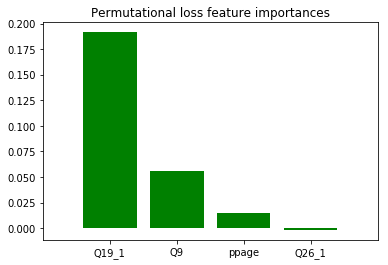

In [38]:
plv_rfc = PerturbationLossVisualizer(rfc, x, y)
plv_rfc.draw_permutational_loss_importance_plot()

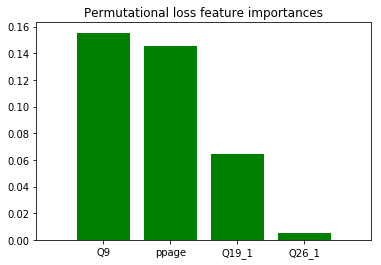

In [39]:
plv_svm = PerturbationLossVisualizer(svm, x, y)
plv_svm.draw_permutational_loss_importance_plot()

Porównując obydwa wykresy widzimy, że poza niską wartością dla zmiennej Q26_1, pozostałe zmienne są traktowane przez model z różnymi priorytetami. Dla lasu losowego najważniejszą zmienną jest zmienna Q19_1, natomiast pozostałe zmienne odgrywają marginalną rolę. W przypadku maszyny wektorów wspierających istotne są zmienne Q9 i ppage, natomiast zmienna Q19_1 odgrywa drugorzędną rolę. 

W naszym przypadku zmienne Q9 i ppage są silnie skorelowane, zatem SVM korzysta z nich 'po równo', natomiast las losowy najprawdopodobniej umieszcza w korzeniu każdego drzewa decyzyjnego zmienną Q19_1, stąd jej zaburzenie istotnie wpływa na predykcje modelu.

# Zobaczmy co się dzieje dla najbardziej różnicującej zmiennej

Jest to zmienna 'ppage'.

In [40]:
class CeterisParibusPlotter(object):
    def __init__(self, clf, x):
        self.clf = clf
        self.x = x
        
    def draw_ceteris_paribus_plot(self, observation, column):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        original_position = observation[column].loc[0]
        print(original_position)
        ranges = []
        scores = []
        i = 0
        
        # find scores for all hypotetical observations
        for value in range(mini, maxi + 1):
            observation[column] = value
            score = self.clf.predict_proba(observation)[0, 1]
            if value == original_position:
                original_score = score
                
            scores.append(score)
            ranges.append(i)
            i += 1

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=scores)
        ax.set_title('Ceteris Paribus profile for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.scatter(x=[original_position], y=[original_score], marker='o', s=100)
        plt.show()
        
        return

In [41]:
class AccumulatedLocalEffectsPlotter(CeterisParibusPlotter):
    def draw_accumulated_local_effects_plot(self, column, window_size=1):
        mini, maxi = int(min(self.x[column])), int(max(self.x[column]))
        ale = []
        
        # find ALE statistics
        for value in range(mini, maxi + 1):
            neighbours = self.x[(self.x[column] >= value - window_size) &
                                (self.x[column] <= value + window_size)].copy()
            
            neighbours[column] = value - window_size
            scores_lower = self.clf.predict_proba(neighbours)[:, 1]
            
            neighbours[column] = value + window_size
            scores_upper = self.clf.predict_proba(neighbours)[:, 1]
            
            
            ale.append((scores_upper - scores_lower).mean())
            
        ale = ale - np.array(ale).mean()

        # draw the plot
        plt.figure(figsize=(10, 10))
        ax = sns.lineplot(x=range(mini, maxi + 1),
                          y=ale)
        ax.set_title('Accumulated Local Effects plot for variable {}'.format(column))
        ax.set_ylabel(column)
        
        plt.show()
        return

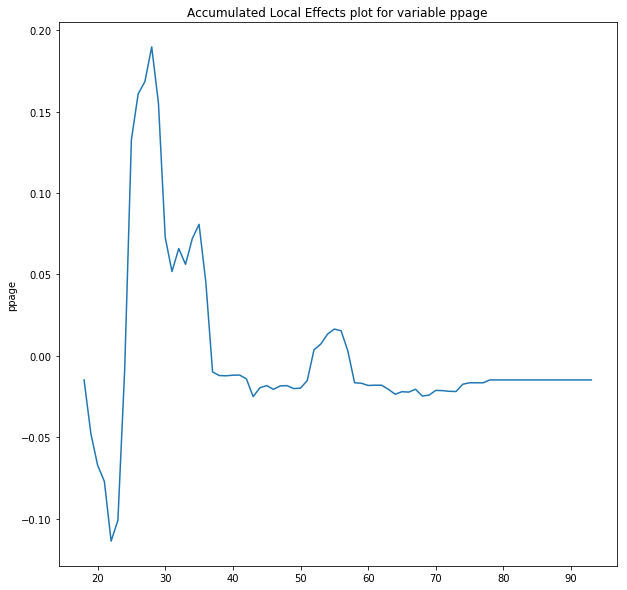

In [55]:
alep_rfc = AccumulatedLocalEffectsPlotter(rfc, x)
alep_rfc.draw_accumulated_local_effects_plot('ppage', 3)

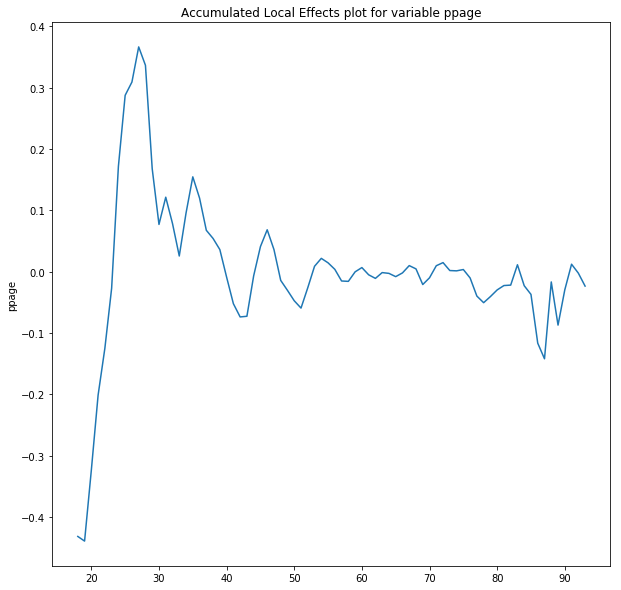

In [56]:
alep_svm = AccumulatedLocalEffectsPlotter(svm, x)
alep_svm.draw_accumulated_local_effects_plot('ppage', 3)

ALE ploty dla zmiennej 'ppage' dla obydwu modeli mają zbliżoną trajektorię. Wykres dla maszyny wektorów wspierających jest bardziej postrzępiony, co wynika z faktu, że las losowy przypisuje tej zmiennej małą wagę przy ostatecznej predykcji, natomiast SVM ma gładkie granice decyzyjne.